# Recurrent Neural Networks in Chainer
### This builds on the [first tutorial](https://github.com/MannyKayy/tutorials/blob/master/chainer/Chainer_Tutorial_1.ipynb), which covered CNNs.

#### Prerequisites: [Recurrent Neural Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), [Chainer RNN tutorial](http://docs.chainer.org/en/stable/tutorial/recurrentnet.html)
#### Recommended Read : [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

## Part 1
Modelling a sine function with a simple RNN.
#### Generating training data
The data generation scheme is pretty simply, generate a 10,000 long sequence of numbers and feed them to a sine function.

In [1]:
import numpy as np

In [2]:
data = np.arange(0,1000, 0.1, dtype=np.float32)

data[0:10]

array([ 0.        ,  0.1       ,  0.2       ,  0.30000001,  0.40000001,
        0.5       ,  0.60000002,  0.69999999,  0.80000001,  0.90000004], dtype=float32)

In [3]:
train_data = np.sin(data)

Lets plot out the training data and observe it's structure

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

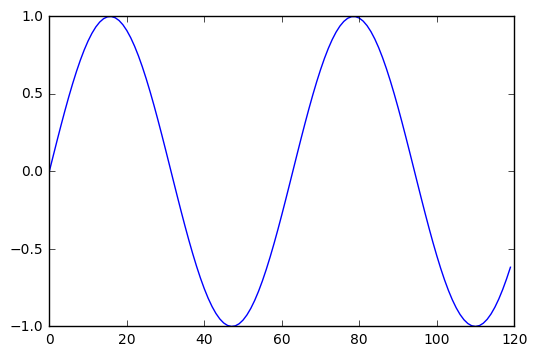

In [5]:
plt.plot(train_data[0:120])

#### Model

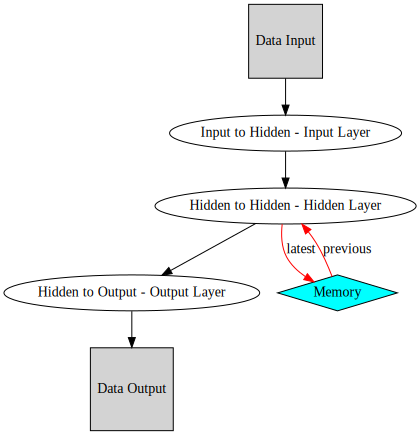

In [6]:
# Some Visualisation stuff
# Feel free to ignore this code block and just view the graphic below
from graphviz import Digraph

dot = Digraph('SimpleRNN0','Basic RNN 0')

dot.node('x2i', 'Data Input',shape = 'square', style='filled')
dot.node('i2h', 'Input to Hidden - Input Layer')
dot.node('h2h', 'Hidden to Hidden - Hidden Layer')
dot.node('h2y', 'Hidden to Output - Output Layer')
dot.node('y2o', 'Data Output',shape = 'square', style='filled')
dot.node('mem', 'Memory',shape = 'diamond', style='filled', fillcolor='cyan')

dot.edge('x2i', 'i2h')
dot.edge('i2h','h2h')
dot.edge('h2h','h2y')
dot.edge('h2y','y2o')
dot.edge('h2h','mem', color = 'red', label='latest')
dot.edge('mem','h2h', color = 'red', label='previous')
dot

The RNN model consists of 3 linear (*Wx+b*) layers and a memory (so to speak).  
Data comes from the input block into the input layer, where it is initially processed.  
It is then passed to a hidden layer which processes it while considering what it has in memory from previous calculations.  
The output from the hidden layer is then split into two, one copy is sent to the output layer and the other (latest) copy is cached into the memory.  
The output layer does some final processing and outputs the results.

In [7]:
import chainer.links as L
import chainer.functions as F
from chainer import Chain, Variable, optimizers, optimizer

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5103)


*Note: An alternative approach to adding links in a chain class is via the *add_link()* function as shown below.*  
*We are not using biases in the linear layers so that the visualisations (shown later) are clearer *

In [8]:
class SimpleRNN0(Chain):
    def __init__(self, dim_input, n_hidden):
        super().__init__()
        
        # Input to hidden unit
        self.add_link('i2h',L.Linear(dim_input,n_hidden, nobias=True))
        
        # Hidden to hidden unit
        self.add_link('h2h',L.Linear(n_hidden,n_hidden, nobias=True))
        
        # Hidden unit to output
        self.add_link('h2y',L.Linear(n_hidden,dim_input, nobias=True))
        
        
        # Recurrent hidden state (or memory)
        self.mem = np.ones((1,3),dtype=np.float32)
        
    def __call__(self,x):
        
        # Process new input
        hx = self.i2h(x)
        
        # Process stored memory
        hh = self.h2h(self.mem)
        
        # Calculate a new memory state while considering
        # the old memory and the new input
        h =  F.tanh(hx + hh)
        
        # Replace the old memory state with the latest one.
        self.mem = h
        
        # Process and return an output given the new memory state
        return self.h2y(h) 

Unrolling this function:
    
![RNN-Diagram](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

where A is the memory, hidden state/vector.

And in the models foward call, we carry out the following operations:  
$$h_t = \tanh(W_1x + W_2h_{t-1})$$  
$$y_t = W_3h_t $$

#### Loss function
Since we are modeling a simple one dimensional signal, we can use a *"mean squared error"* loss function.  
There are alternative [loss functions](http://docs.chainer.org/en/stable/reference/functions.html#loss-functions) packaged with chainer.

We also only care about optimising the 1-foward-step loss, so we can tell the classifier not to compute the accuracy.

In [9]:
model_0 = SimpleRNN0(1,3)
model_0C = L.Classifier(model_0,F.mean_squared_error)
model_0C.compute_accuracy = False

#### Optimizer

And lets setup the optimizer with our model

In [10]:
opt = optimizers.Adam()
opt.setup(model_0C)

### Unrolling the computation graph

Lets have a look at the computation graph for the first timestep (iteration).

In [11]:
temp_loss = model_0C(Variable(np.asarray(train_data[0], np.float32).reshape(1,1)),
                     Variable(np.asarray(train_data[1], np.float32).reshape(1,1)))

In [12]:
import chainer.computational_graph as c
import pydot_ng as pd
from IPython.display import Image, display

## Draw graph
def draw_graph(name):   
    graph =  pd.graph_from_dot_data(c.build_computational_graph((name,)).dump())
    return display(Image(graph.create_png()))

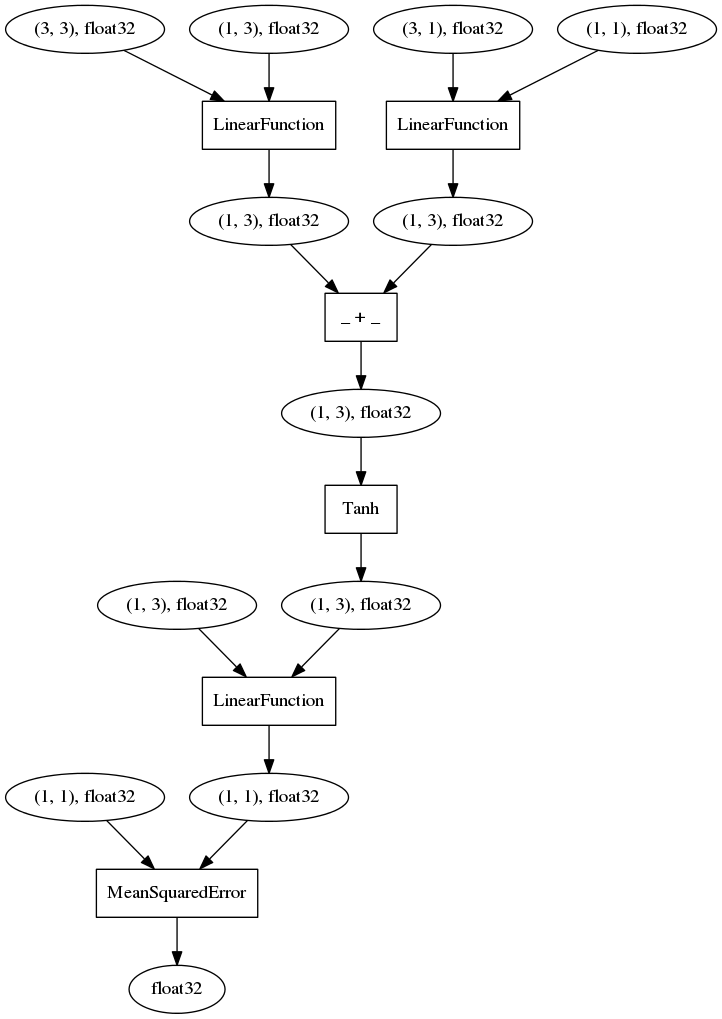

In [13]:
draw_graph(temp_loss)

From top to bottom, we have our 1x1 data input that is being passed into a linear function along with a 3x1 weight matrix. The linear function takes the dot product between them and outputs a 1x3 vector. This is the first step in the foward pass of the *SimpleRNN0* (i.e *"h = self.i2h(x)"*). We then get the 1x3 memory vector and multiply it by the 3x3 weights of the hidden layer. The resulting 1x3 vectors from both computations are added and passed to a *tanh* non-linearity.   If you trace down the rest of the graph, it follows the exact operations that occur during the first foward pass of *SimpleRNN0*.

Although it looks simple right now, the power of this model lays in it's ability to deal with sequential data (or data with a time dimension). The key insight is that if we can store some memory of previous computations and share parameters across time, we can learn to guide future processing.

*Note*: we are minimising a loss over time so we must keep track of how well the model performs after a certain number of iterations. This is simply done by summing up the loss of each iteration over some predifined interval.

Lets move to the second timestep in our model and view what the computational graph looks like.

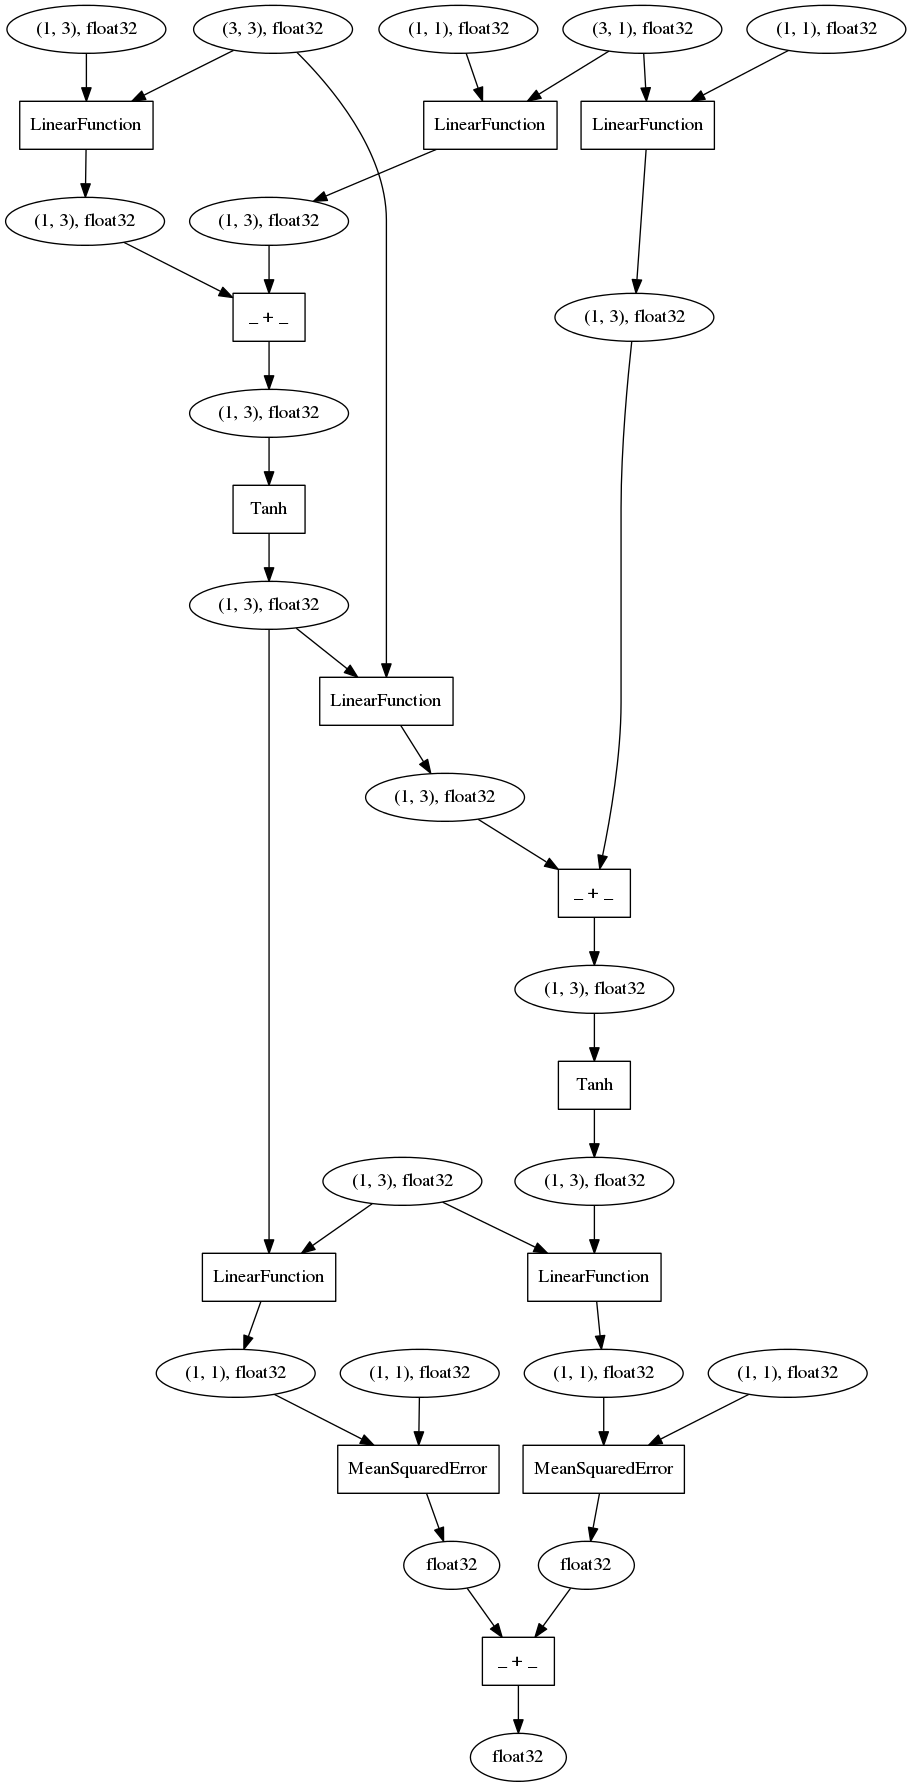

In [14]:
temp_loss += model_0C(Variable(np.asarray(train_data[1], np.float32).reshape(1,1)),
                     Variable(np.asarray(train_data[2], np.float32).reshape(1,1)))

draw_graph(temp_loss)

It's starting to look abit more complicated but there are some key things to note about the graph. First of all, the parameter (or weight) matrices are the only nodes with multiply edges coming from them (2 edges in this case). This is because these matrices are shared across time (or iterations) and in this case, we happen to be on the 2nd timestep (so an edge per timestep). Also note that we are also computing the loss function twice (once for each iteration) and summing up the error.

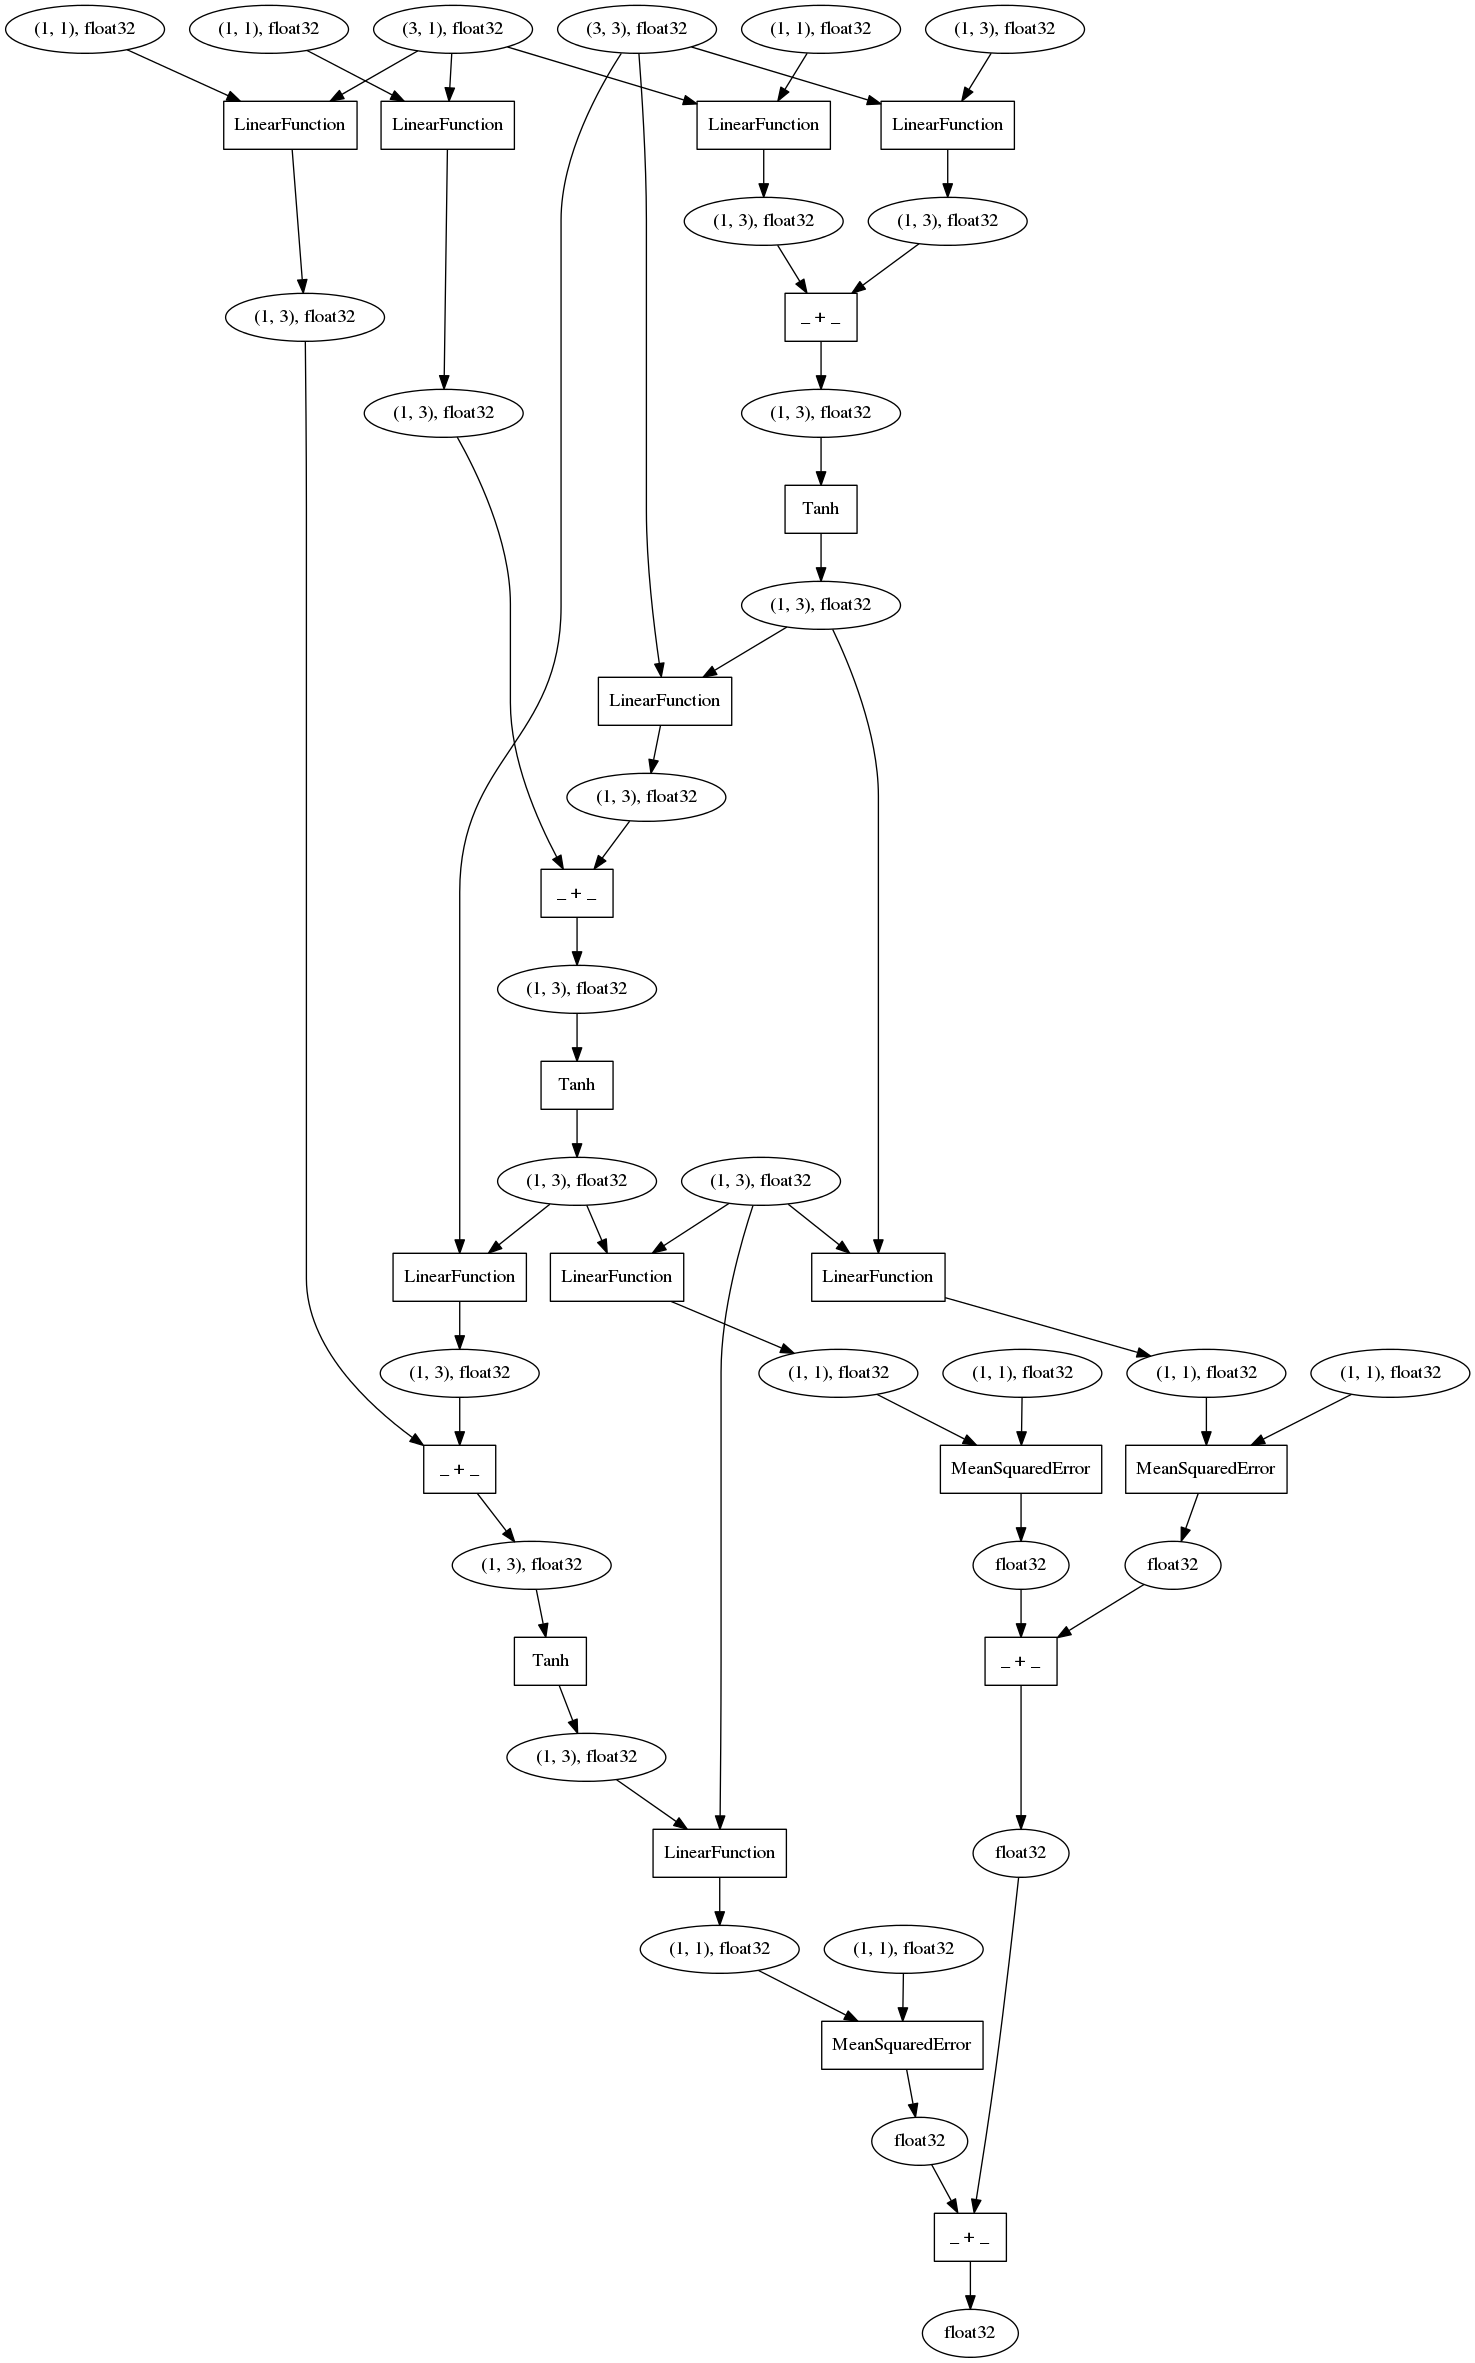

In [15]:
temp_loss += model_0C(Variable(np.asarray(train_data[2], np.float32).reshape(1,1)),
                      Variable(np.asarray(train_data[3], np.float32).reshape(1,1)))


draw_graph(temp_loss)

*Note*: The number of edges from the weight matrices has increased to 3 for the 3 respective timesteps. This graph stores the history of all operations carried out on the data using the parameters (weights). After some set number of iterations (of our choosing), we ask chainer to backpropagate the error through-out the graph and it traverses the graph from bottom to top.  

*Note*: We have been storing this graph and updating it through the *Variable* **temp_loss**. Remember that chainer variables support backpropagation through the call to the *.backward()* method. We will use this method to evaluate the graph and update our gradient arrays.

In [16]:
# Make sure our models gradient arrays are empty
model_0C.cleargrads()

# Backpropagate from this variable and accumulate gradients to the models gradient array
temp_loss.backward()

# Update the model parameters
opt.update()

The "temp_loss" variable still holds a computation graph with a history of all computations so far. When modelling long sequences with lots of training data, this graph will grow too large to be stored in memory. Since we have already evaluated it and updated the model parameters, we can delete the computation history.This can be done by unchaining the computational graph which cleans up the computational graph up until the *temp_loss* variable.

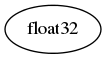

array(0.0, dtype=float32)

In [17]:
# Reset the loss to 0
temp_loss.data.fill(0)

# Unchain the computational graph
temp_loss.unchain_backward()

draw_graph(temp_loss)
temp_loss.data

#### Training

So lets wrap this all in a training loop and model the sine wave.

In [18]:
# define model
model_0 = SimpleRNN0(1,3)
model_0C = L.Classifier(model_0,F.mean_squared_error)
model_0C.compute_accuracy = False

# load optimizer
opt = optimizers.Adam()
opt.setup(model_0C)

In [19]:
# Our training function
def train_SimpleRNN0(model, nb_epochs = 1, backprop_timer = 10):
    accumulated_loss = 0
    loss_i = 0 # Current Loss
    loss_log = [] # Loss history
    loss_avg = 0 # 100 iteration loss average

    # training loop
    for epoch in range(nb_epochs):
        for i in range(train_data.shape[0]-1):
            x = Variable(np.asarray(train_data[i], np.float32).reshape(1,1))
            t = Variable(np.asarray(train_data[i+1], np.float32).reshape(1,1))

            # Foward Pass
            loss_i = model(x,t)

            # Loss aggregation
            accumulated_loss += loss_i

            # Track the average loss every 100 iterations.
            loss_avg += accumulated_loss.data       
            if (i % 100) == 0:          
                loss_log.append(np.mean(loss_avg))
                loss_avg = 0

            #Backward pass and update
            if (i+1) % backprop_timer == 0:
                model.cleargrads()
                accumulated_loss.backward()
                accumulated_loss.unchain_backward()
                accumulated_loss.data.fill(0)
                opt.update()
        
        if epoch % 10 == 0:
            print('Epoch: ', epoch)
        
    return loss_log

In [20]:
# The evaluation loop
def evaluate(model,num, origin=0):
    evaluator = model.copy()
    
    # Don't store computation history
    evaluator.volatile = 'on'
    
    # Reset memory
    evaluator.mem = np.ones(
        (1,evaluator.h2h.W.data.shape[0]),
        dtype=np.float32)

    # Evaluate for a single time step to get first output
    p = evaluator(np.array([[origin]],np.float32))
    preds = []
    
    # Feed that into the next timestep and repeat for num iterations
    for i in range(num):
        p = evaluator(p)
        preds.append(p.data[0])

    return preds

Epoch:  0
Epoch:  10
Epoch:  20
Epoch:  30
Epoch:  40


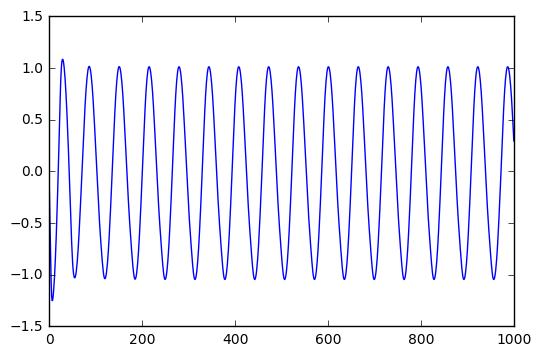

In [21]:
loss = train_SimpleRNN0(model_0C,50)
plt.plot(evaluate(model_0C.predictor,1000))

0.0031095682207649133

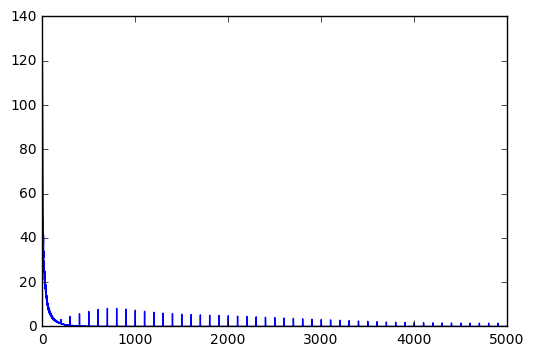

In [22]:
plt.plot(loss)
loss[-1]

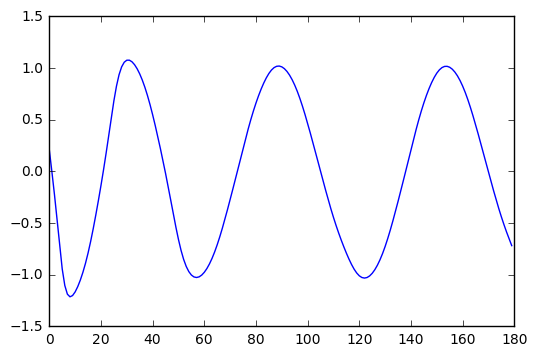

In [23]:
plt.plot(evaluate(model_0C.predictor,180,0.9))

*Note*: Results will not be consistent because this is a simple RNN and RNNs in general are hard to train.. For this problem, the solution is to train for much longer.

A keen observer may have noticed that we could update the model parameters after every iteration instead of aggregating the loss over several iterations. This can be done in this code by reducing the *"backprop_timer"* value. What would be the best setting for *"backprop_timer"* given our current knowledge of RNNs and the data we are modelling in order to lower the loss further?


Below is a recurrent network which does not aggregate loss over time and instead backpropagates every individual loss.

In [24]:
# define model
model_1 = SimpleRNN0(1,3)
model_1C = L.Classifier(model_1,F.mean_squared_error)
model_1C.compute_accuracy = False

# load optimizer
opt = optimizers.Adam()
opt.setup(model_1C)

Training while unchaining at every iteration

Epoch:  0
Epoch:  10
Epoch:  20
Epoch:  30
Epoch:  40


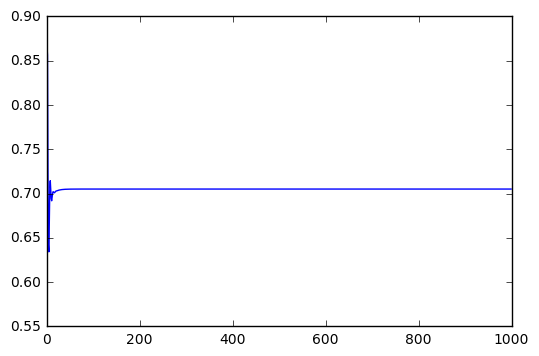

In [25]:
loss = train_SimpleRNN0(model_1C,50,1)  # Very slow
plt.plot(evaluate(model_1C.predictor,1000))

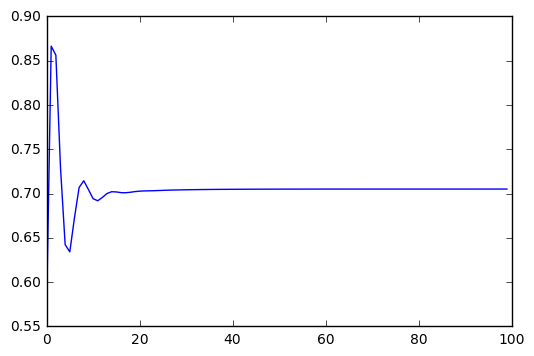

In [26]:
plt.plot(evaluate(model_1C.predictor,100))

So what's going on here?  

Play around with the number of epochs being trained over (e.g. reduce it)

### Mini-batches
To use mini-batches in chainer, we have to ensure that the hidden state also considers the batch dimension.  
The rest of the code is self explanatory.

In [27]:
class SimpleRNN1(Chain):
    def __init__(self, dim_input, n_hidden, batch_dim):
        super().__init__()
        
        self.add_link('i2h',L.Linear(dim_input,n_hidden, nobias=True))
        self.add_link('h2h',L.Linear(n_hidden,n_hidden, nobias=True))
        self.add_link('h2y',L.Linear(n_hidden,dim_input, nobias=True))

        # Recurrent state modified for mini-batches
        self.mem = np.ones((batch_dim,n_hidden),dtype=np.float32)
        
    def __call__(self,x):
        
        hx = self.i2h(x)
        hh = self.h2h(self.mem)
        h =  F.tanh(hx + hh)
        
        self.mem = h
        
        return self.h2y(h) 

In [28]:
# Our training function
def train_SimpleRNN1(model, nb_epochs = 1, backprop_timer = 10, batchsize = 100):
    
    dataset_length = train_data.shape[0]    
    nb_batches = dataset_length // batchsize
    batch_index = list(range(batchsize))
    
    
    accumulated_loss = 0
    loss_i = 0 # Current Loss
    loss_log = [] # Loss history
    loss_avg = 0 # 100 iteration loss average

    # training loop
    for epoch in range(nb_epochs):
        for i in range(batchsize):
            x = [train_data[(batch_iterator * nb_batches + i) % dataset_length] for batch_iterator in batch_index]
            t = [train_data[(batch_iterator * nb_batches + i+1) % dataset_length] for batch_iterator in batch_index]

            x = Variable(np.asarray(x, np.float32).reshape(len(batch_index),1))
            t = Variable(np.asarray(t, np.float32).reshape(len(batch_index),1))

            # Foward Pass
            loss_i = model(x,t)

            # Loss aggregation
            accumulated_loss += loss_i

            # Track the average loss every 100 iterations.
            loss_avg += accumulated_loss.data       
            if (i % 100) == 0:          
                loss_log.append(np.mean(loss_avg))
                loss_avg = 0

            #Backward pass and update
            if (i+1) % backprop_timer == 0:
                model.cleargrads()
                accumulated_loss.backward()
                accumulated_loss.unchain_backward()
                accumulated_loss.data.fill(0)
                opt.update()
        
        if epoch % 10 == 0:
            print('Epoch: ', epoch)
        
    return loss_log

In [29]:
# define model
batchsize = 300 #50, 100, 200, 300
model_2 = SimpleRNN1(1,3, batchsize)
model_2C = L.Classifier(model_2,F.mean_squared_error)
model_2C.compute_accuracy = False

# load optimizer
opt = optimizers.Adam()
opt.setup(model_2C)

Epoch:  0
Epoch:  10
Epoch:  20
Epoch:  30
Epoch:  40
Epoch:  50
Epoch:  60
Epoch:  70
Epoch:  80
Epoch:  90
Epoch:  100
Epoch:  110
Epoch:  120
Epoch:  130
Epoch:  140
Epoch:  150
Epoch:  160
Epoch:  170
Epoch:  180
Epoch:  190
Epoch:  200
Epoch:  210
Epoch:  220
Epoch:  230
Epoch:  240
Epoch:  250
Epoch:  260
Epoch:  270
Epoch:  280
Epoch:  290


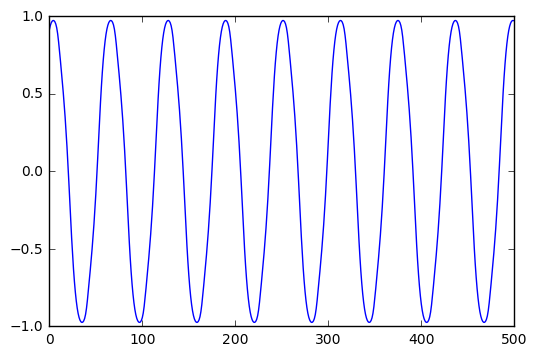

In [30]:
nb_epochs = 300 #1, 50, 100
backprop_interval = 10 #1, 5, 10


loss = train_SimpleRNN1(
    model_2C,
    nb_epochs=nb_epochs,
    backprop_timer=backprop_interval,
    batchsize=batchsize)

plt.plot(evaluate(model_2C.predictor,1000)[500:1000])

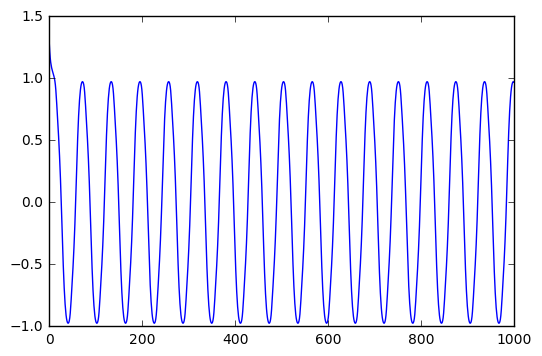

In [31]:
plt.plot(evaluate(model_2C.predictor,1000,.9))

Observations about training RNNs (when using unaligned mini-batches):  
Some (hand-wavy) observations from training SimpleRNN1 (not mutually exclusive).  
1. By reducing the backpropagation interval, network converges to worse solution when modelling long sequences.
2. A model with a longer backpropagation interval requires more epochs to converge to a good solution.
    - A contributing factor is that the further back we have to propagate, the smaller the gradients become and thus the more epochs we need to update the weights via backprop.
3. The backprop interval must be long enough to capture the structure in data but short enough not to kill the gradients.
5. As your batchsize increase, you should reduce your bptt interval (for faster convergence).
6. Really small intervals (e.g. 1), work well with small batch sizes (e.g. 50)
7. Multiple restarts are a must!

### Using trainer

To use trainer with our sequential data, we need to create a standard python iterator for it that returns the training data in whatever shape we need to process it.

In [32]:
from __future__ import division
from chainer.dataset import Iterator

Simple iterator

In [33]:
# Iterator for the sine function with some additional methods through the property decorator
class SineIterator1(Iterator):
    def __init__(self, dataset, batch_size, repeat=True):
        self.dataset = dataset
        self.batch_size = dataset.shape[0] // batch_size
        self.repeat = repeat
        
        # True if the epoch is incremented at the last iteration.
        self.is_new_epoch = False
        
        self.epoch = 0
        # Number of calls to __next__
        self.iteration = 0
        
        # Offset indices into the dataset
        self.dataset_length = dataset.shape[0]
        self.nb_batches = self.dataset_length // self.batch_size 
        self.offsets = [batch * self.batch_size for batch in range(self.nb_batches)]
        
    def __next__(self):
        if not self.repeat and self.epoch > 0:
            raise StopIteration
            
        # Iterator
        # Return item in each batch at some specific position
        x_itr = [item + self.iteration for item in self.offsets]
        x = (self.dataset[a % self.dataset_length] for a in x_itr)
        
        self.iteration += 1
        
        # Return target (x+1) for each item x
        t_itr = [item + self.iteration for item in self.offsets]
        t = (self.dataset[b % self.dataset_length] for b in t_itr)
        
        # Current epoch as a whole number
        epoch = self.iteration * self.batch_size // self.dataset_length
        
        self.is_new_epoch = self.epoch < epoch
        if self.is_new_epoch: self.epoch = epoch
        
        return list(zip(x,t))
    
    @property
    def epoch_detail(self):
        return self.iteration * self.batch_size / self.dataset_length
    
    def serialize(self, serializer):
        self.iteration = serializer('iteration', self.iteration)
        self.epoch = serializer('epoch', self.epoch)

Reload our model and pass through the batch_size

In [34]:
# define model
batchsize = 100 #50, 100, 200, 300
model_2 = SimpleRNN1(1,3,batchsize)
model_2C = L.Classifier(model_2,F.mean_squared_error)
model_2C.compute_accuracy = False

# load optimizer
opt = optimizers.Adam()
opt.setup(model_2C)

# Training loop
nb_epochs = 1000 #1, 50, 100
backprop_interval = 10 #1, 5, 10


In [35]:
train_iter = SineIterator1(train_data,batchsize)

In [36]:
from chainer import training, dataset
from chainer.training import extensions

/opt/conda/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


We also need to customize the standard updater's *"update_core"* function which calls our iterator and passes the data from it to the model. It then calls our model and updates the parameters.

*Note*: We are just wrapping up our training loops and data iterators (from before) in classes so that we can use trainer and related chainer goodies.

In [37]:
class BPTTUpdater(training.StandardUpdater):
    def __init__(self, train_iter, optimizer, bprop_len, device):
        super(BPTTUpdater, self).__init__(
            train_iter, optimizer, device=device)
        self.bprop_len = bprop_len
    
    def update_core(self):
        loss = 0
        
        train_iter = self.get_iterator('main')
        optimizer = self.get_optimizer('main')
        model = optimizer.target
        
        for i in range(self.bprop_len):
            batch = train_iter.next()
            x, t = dataset.concat_examples(batch)
            x = np.asarray(x, np.float32).reshape(len(x),1)
            t = np.asarray(t, np.float32).reshape(len(t),1)
            loss += model(Variable(x), Variable(t))

        model.cleargrads()
        loss.backward()
        loss.unchain_backward()
        optimizer.update()

In [38]:
updater = BPTTUpdater(train_iter,opt,backprop_interval,-1)

trainer = training.Trainer(updater,(nb_epochs,'epoch'))

trainer.run()

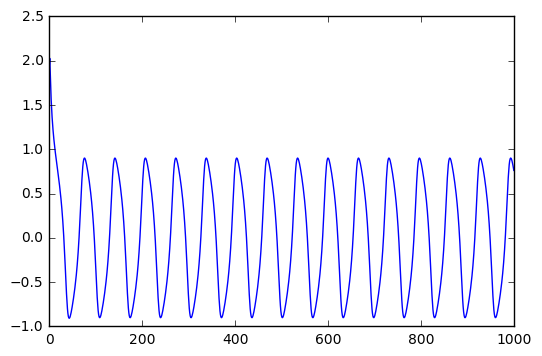

In [39]:
plt.plot(evaluate(model_2C.predictor,1000))

Using sequential mini-batches

*Note*: sineiterator2 sequentially sends batches of size *batchsize* to the model.

In [40]:
# Iterator for the sine function with some additional methods through the property decorator
class SineIterator2(Iterator):
    def __init__(self, dataset, batch_size, repeat=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.repeat = repeat
        
        # True if the epoch is incremented at the last iteration.
        self.is_new_epoch = False
        
        self.epoch = 0
        # Number of calls to __next__
        self.iteration = 0
        
        # Batch offset indices into the dataset
        self.dataset_length = dataset.shape[0]
        self.nb_batches = self.dataset_length // batchsize 
        self.offsets = [batch * self.batch_size for batch in range(self.nb_batches)]
        
    def __next__(self):
        if not self.repeat and self.epoch > 0:
            raise StopIteration
            
        # Iterator
        # Return x batch
        x_itr = np.arange(self.offsets[self.iteration % self.nb_batches],
                           self.offsets[self.iteration % self.nb_batches] 
                           + self.batch_size)
        
        #x_itr = np.random.permutation(x_itr) # Randomize batch
        
        x = self.dataset[x_itr % self.dataset_length]
        
        
        # return target batch
        t = self.dataset[(x_itr + 1) % self.dataset_length]        
        
        
        self.iteration += 1
        
        # Current epoch as a whole number
        epoch = self.iteration * self.batch_size // self.dataset_length
        
        self.is_new_epoch = self.epoch < epoch
        if self.is_new_epoch: self.epoch = epoch
        
        return list(zip(x,t))
    
    @property
    def epoch_detail(self):
        return self.iteration * self.batch_size / self.dataset_length
    
    def serialize(self, serializer):
        self.iteration = serializer('iteration', self.iteration)
        self.epoch = serializer('epoch', self.epoch)

In [41]:
# define model
batchsize = 100 #50, 100, 200, 300
model_2 = SimpleRNN1(1,3, batchsize)
model_2C = L.Classifier(model_2,F.mean_squared_error)
model_2C.compute_accuracy = False

# load optimizer
opt = optimizers.Adam()
opt.setup(model_2C)
model_2C

In [42]:
# Training loop
nb_epochs = 50 #1, 50, 100
backprop_interval = 10 #1, 5, 10

In [43]:
train_iter = SineIterator2(train_data,batchsize)

updater = BPTTUpdater(train_iter,opt,backprop_interval,-1)

trainer = training.Trainer(updater,(nb_epochs,'epoch'))

trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'elapsed_time', 'main/loss']), trigger=(1000, 'iteration'))
trainer.extend(extensions.PlotReport(['main/loss'], file_name='SimpleRNN1_loss.png'))
trainer.extend(extensions.ProgressBar(update_interval=500))


trainer.run()

     total [##################################################] 100.00%
this epoch [..................................................]  0.00%
       500 iter, 50 epoch / 50 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.


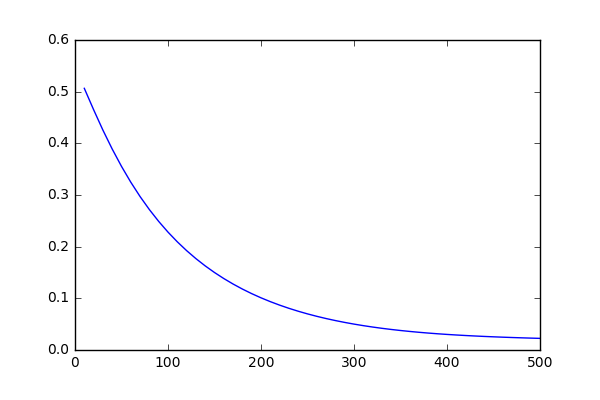

In [44]:
Image(filename='result/SimpleRNN1_loss.png')

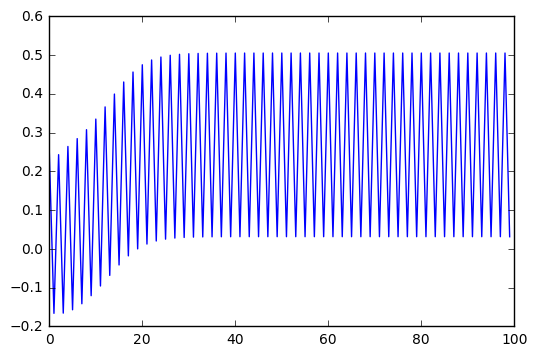

In [45]:
plt.plot(evaluate(model_2C.predictor,100))

What is going on here?

Why is it hard to train sequential batches for this dataset?

Could this behaviour be explained by overfitting?

## LSTMs and GRUs

LSTMs and GRUs allow for gradients to flow further back in time.  
Let's implement them and compare results.

In [299]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [300]:
import chainer.links as L
import chainer.functions as F
from chainer import Chain, Variable, optimizers, training, dataset, cuda
from chainer.dataset import Iterator
from chainer.training import extensions

import numpy as np

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline

### RNN types

#### RNN
$h_t = \tanh(W_1x + W_2h_{t-1})$  
$y_t = W_yh_t $

![RNN](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)
#### LSTM
$i_t = \sigma(W^1_ih_{t-1} + W^2_ix + b_i)$  
$o_t = \sigma(W^1_oh_{t-1} + W^2_ox + b_o)$  
$f_t = \sigma(W^1_fh_{t-1} + W^2_fx + b_f)$  

$\tilde{c} = \tanh(W^1_ch_{t-1} + W^2_cx + b_c)$  
$c_t = f_t * c_{t-1} + i_t * \tilde{c}$  

$h_t = o_t * \tanh(c_t) $  
$y_t = W_yh_t $  


![LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)


#### GRU
![GRU](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png)

In [301]:
class Base_RNNs(Chain):
    def __init__(self, input_dim = 1, hidden_units = 3, output_dim=None, rnn_type = "LSTM"):
        
        super().__init__()
        
        self.rnn_type = rnn_type
        
        self.add_link('Wi', L.Linear(hidden_units,hidden_units, nobias=True))
        self.add_link('Wo', L.Linear(hidden_units,hidden_units, nobias=True))
        self.add_link('Wf', L.Linear(hidden_units,hidden_units, nobias=True))
        self.add_link('Wc', L.Linear(hidden_units,hidden_units, nobias=True))
        
        self.add_link('Ui', L.Linear(input_dim,hidden_units))
        self.add_link('Uo', L.Linear(input_dim,hidden_units))
        self.add_link('Uf', L.Linear(input_dim,hidden_units))
        self.add_link('Uc', L.Linear(input_dim,hidden_units))
        
        
        if output_dim is None:
            self.add_link('h2y',L.Linear(hidden_units, input_dim))
        else:
            self.add_link('h2y',L.Linear(hidden_units, output_dim))
        
        self.memory_state = None
        self.cell_state = None
        
        ##Peephole specific
        if rnn_type == "P-LSTM":
            self.add_link('Pi', L.Linear(hidden_units,hidden_units, nobias=True))
            self.add_link('Pf', L.Linear(hidden_units,hidden_units, nobias=True))
            self.add_link('Po', L.Linear(hidden_units,hidden_units, nobias=True))
        
        
    def reset_state(self):
        self.memory_state = None
        self.cell_state = None
        

    def RNN(self, x):
        if self.memory_state is None:
            self.memory_state = F.sigmoid(self.Ui(x))
            
        self.memory_state =  F.tanh(self.Ui(x) + self.Wi(self.memory_state))
        
        return(self.h2y(self.memory_state))

    
    def GRU(self,x):
        if self.memory_state is None:
            self.memory_state = F.sigmoid(self.Ui(x))   
 
        z = F.sigmoid(self.Wi(self.memory_state) + self.Ui(x))
        r = F.sigmoid(self.Wo(self.memory_state) + self.Uo(x))
        
        c = F.tanh(self.Wc((self.memory_state * r)) + self.Uc(x))
        
        h = ((1-z)*c) + (z*self.memory_state)

        self.memory_state = h
        
        return self.h2y(h)        

    
    def LSTM(self,x):
        if self.memory_state is None:
            self.memory_state = F.sigmoid(self.Ui(x))
            self.cell_state = F.tanh(self.Wc(self.memory_state) + self.Uc(x))
        
        input_gate = F.sigmoid(self.Wi(self.memory_state) + self.Ui(x))
        output_gate = F.sigmoid(self.Wo(self.memory_state) + self.Uo(x))
        forget_gate = F.sigmoid(self.Wf(self.memory_state) + self.Uf(x))
        
        c_gate = F.tanh(self.Wc(self.memory_state) + self.Uc(x))
        c = (forget_gate * self.cell_state) + (input_gate * c_gate)
        
        h = output_gate * F.tanh(c)
        
        self.memory_state = h
        self.cell_state = c
        
        return self.h2y(h)       

    
    def Peep_LSTM(self,x):
        
        if self.memory_state is None:
            self.memory_state = F.sigmoid(self.Ui(x))
            self.cell_state = F.tanh(self.Wc(self.memory_state) + self.Uc(x))
            
        input_gate = F.sigmoid(self.Wi(self.memory_state) + self.Ui(x) + self.Pi(self.cell_state))
        forget_gate = F.sigmoid(self.Wf(self.memory_state) + self.Uf(x) + self.Pf(self.cell_state))
        
        c_gate = F.tanh(self.Wc(self.memory_state) + self.Uc(x))
        c = (forget_gate * self.cell_state) + (input_gate * c_gate)
        
        output_gate = F.sigmoid(self.Wo(self.memory_state) + self.Uo(x) + self.Po(c))

        h = output_gate * F.tanh(c)
        
        self.memory_state = h
        self.cell_state = c
        
        return self.h2y(h)

    
    def Coupled_LSTM(self,x):
        if self.memory_state is None:
            self.memory_state = F.sigmoid(self.Ui(x))
            self.cell_state = F.tanh(self.Wc(self.memory_state) + self.Uc(x))
        
        #input_gate = F.sigmoid(self.Wi(self.memory_state) + self.Ui(x))
        output_gate = F.sigmoid(self.Wo(self.memory_state) + self.Uo(x))
        forget_gate = F.sigmoid(self.Wf(self.memory_state) + self.Uf(x))
        
        c_gate = F.tanh(self.Wc(self.memory_state) + self.Uc(x))
        c = (forget_gate * self.cell_state) + ((1-forget_gate) * c_gate)
        
        h = output_gate * F.tanh(c)
        
        self.memory_state = h
        self.cell_state = c
        
        return self.h2y(h)

    
    def __call__(self,x):
        
        if self.rnn_type == "P-LSTM":
            y = self.Peep_LSTM(x)
        if self.rnn_type == "C-LSTM":
            y = self.Coupled_LSTM(x)
        if self.rnn_type == "RNN":
            y = self.RNN(x)
        if self.rnn_type == "GRU":
            y = self.GRU(x)       
        if self.rnn_type == "LSTM":
            y = self.LSTM(x)
        
        return y
        

In [302]:
def create_model(model_type,input_dimension = 1, hidden_units = 3, rnn_type = "LSTM"):
    model = model_type(input_dim = input_dimension,hidden_units = hidden_units,rnn_type = rnn_type)
    model_C = L.Classifier(model,F.mean_squared_error)
    model_C.compute_accuracy = False
    
    opt = optimizers.Adam()
    opt.setup(model_C)
    
    return opt

In [303]:
opt =  create_model(Base_RNNs, rnn_type="GRU")

In [304]:
data = np.arange(0,1000, 0.1, dtype=np.float32)
train_data = np.sin(data)

In [305]:
# Training loop
batchsize = 100
nb_epochs = 500
backprop_interval = 10

In [306]:
# A small extension to clear the output
@training.make_extension()
def clear_screen(trainer):
    clear_output()

In [307]:
class SineIteratorEven(Iterator):
    ''' Batch iterator that selects offsets evenly spaced into the dataset '''
    def __init__(self, dataset, batch_size, repeat=True):
        self.dataset = dataset
        self.batch_size = dataset.shape[0] // batch_size
        self.repeat = repeat
        
        # True if the epoch is incremented at the last iteration.
        self.is_new_epoch = False
        
        self.epoch = 0
        # Number of calls to __next__
        self.iteration = 0
        
        # Offset indices into the dataset
        self.dataset_length = dataset.shape[0]
        self.nb_batches = self.dataset_length // self.batch_size 
        self.offsets = [batch * self.batch_size for batch in range(self.nb_batches)]
        
    def __next__(self):
        if not self.repeat and self.epoch > 0:
            raise StopIteration
            
        # Iterator
        # Return item in each batch at some specific position
        x_itr = [item + self.iteration for item in self.offsets]
        x = (self.dataset[a % self.dataset_length] for a in x_itr)
        
        self.iteration += 1
        
        # Return target (x+1) for each item x
        t_itr = [item + self.iteration for item in self.offsets]
        t = (self.dataset[b % self.dataset_length] for b in t_itr)
        
        # Current epoch as a whole number
        epoch = self.iteration * self.batch_size // self.dataset_length
        
        self.is_new_epoch = self.epoch < epoch
        if self.is_new_epoch: self.epoch = epoch
        
        return list(zip(x,t))
    
    @property
    def epoch_detail(self):
        return self.iteration * self.batch_size / self.dataset_length
    
    def serialize(self, serializer):
        self.iteration = serializer('iteration', self.iteration)
        self.epoch = serializer('epoch', self.epoch)
        
class BPTTUpdater(training.StandardUpdater):
    ''' Updater for RNNs '''
    def __init__(self, train_iter, optimizer, bprop_len, device):
        super(BPTTUpdater, self).__init__(
            train_iter, optimizer, device=device)
        self.bprop_len = bprop_len
    
    def update_core(self):
        loss = 0
        
        train_iter = self.get_iterator('main')
        optimizer = self.get_optimizer('main')
        model = optimizer.target
        
        for i in range(self.bprop_len):
            batch = train_iter.next()
            x, t = dataset.concat_examples(batch)
            x = np.asarray(x, np.float32).reshape(len(x),1)
            t = np.asarray(t, np.float32).reshape(len(t),1)
            loss += model(Variable(x), Variable(t))

        model.cleargrads()
        loss.backward()
        loss.unchain_backward()
        optimizer.update()

In [308]:
train_iter = SineIteratorEven(train_data,batchsize)

updater = BPTTUpdater(train_iter,opt,backprop_interval,-1)

trainer = training.Trainer(updater,(nb_epochs,'epoch'))

trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'elapsed_time', 'main/loss']), trigger=(100, 'iteration'))
trainer.extend(extensions.PlotReport(['main/loss'], file_name='SimpleLSTM1_loss.png'))
trainer.extend(extensions.ProgressBar(update_interval=100))

trainer.extend(clear_screen,trigger=(99, 'iteration'))

trainer.run()

491         201.713       0.000695134  
492         202.109       0.000695093  
493         202.505       0.000695052  
494         202.9         0.000695012  
495         203.297       0.000694972  
496         203.694       0.000694932  
497         204.089       0.000694893  
498         204.484       0.000694855  
499         204.878       0.000694817  
500         205.274       0.000694779  
     total [##################################################] 100.00%
this epoch [..................................................]  0.00%
      5000 iter, 500 epoch / 500 epochs
    24.329 iters/sec. Estimated time to finish: 0:00:00.


In [309]:
# The evaluation loop
def evaluate(optimizer, num, origin=0):
    model = optimizer.target.predictor
    evaluator = model.copy()
    
    # Don't store computation history
    evaluator.volatile = 'on'
    
    # Reset memory
    evaluator.reset_state()
    
    # Evaluate for a single time step to get first output
    p = evaluator(np.array([[origin]],np.float32))
    preds = []
    
    # Feed that into the next timestep and repeat for num iterations
    for i in range(num):
        p = evaluator(p)
        preds.append(p.data[0])

    return preds

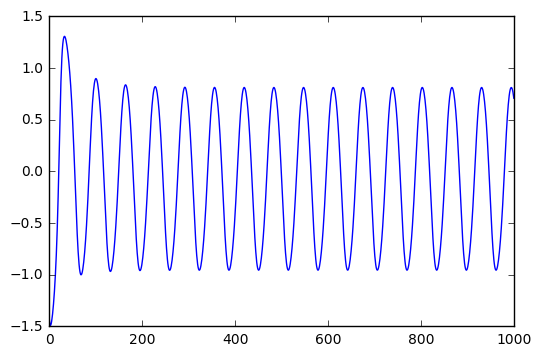

In [310]:
plt.plot(evaluate(opt,1000,-90))

# Complex RNNs

![](https://image.slidesharecdn.com/2016-clipping-lstm-gru-urnn2851-160727133046/95/2016-clipping-lstm-gru-urnn-17-638.jpg?cb=1469626253)

In [311]:
from chainer import reporter

class BRNN(Chain):
    
    def __init__(self, input_dim=1, hidden_units=3, output_dim = None, rnn_type = "GRU"):
        
        super().__init__(    
        fwd_rnn = Base_RNNs(input_dim = input_dim, hidden_units = hidden_units,
                            output_dim=output_dim, rnn_type = rnn_type),
            
        bwd_rnn = Base_RNNs(input_dim = input_dim, hidden_units = hidden_units,
                            output_dim=output_dim, rnn_type = rnn_type))

    def reset_state(self):
        self.fwd_rnn.memory_state = None
        self.fwd_rnn.cell_state = None
        
        self.bwd_rnn.memory_state = None
        self.bwd_rnn.cell_state = None
        
    def __call__(self, sequence, targets = None):
        
        batch_size = len(sequence)
        sequence_length = len(sequence[0])
        
        sequence = np.asarray(sequence, np.float32)
        
        fwd_pass = [self.fwd_rnn(Variable(cuda.to_gpu(sequence[:,item].reshape(batch_size,1)))) for item in range(sequence_length)]
        bwd_pass = [self.bwd_rnn(Variable(cuda.to_gpu(sequence[:,item].reshape(batch_size,1)))) for item in range(sequence_length - 1, -1, -1)]      
        
        joint_pass = [fwd_pass[i] + bwd_pass[i] for i in range(sequence_length)]
        
        if targets is None:
            return joint_pass
        
        loss = 0
        
        targets = np.asarray(targets,np.float32).reshape(batch_size, sequence_length,1)
        
        
        for i in range(sequence_length):
            loss += F.mean_squared_error(joint_pass[i], targets[:,i])
        
        reporter.report({'loss' : loss}, self)
        
        return loss
        
        

In [312]:
from chainer.functions.loss import mean_squared_error
from chainer import Chain
from chainer import reporter
from numpy import asarray

class Classifier_BRNN(Chain):
    
    def __init__(self, predictor, lossfun=mean_squared_error.mean_squared_error):
        
        super().__init__(predictor = predictor)
        self.lossfun = lossfun
        self.y_list = None
        self.loss = None
        
    def __call__(self,*args):

        assert len(args) >= 2

        x = args[:-1]
        t = args[-1]

        self.y_list = None
        self.loss = 0

        self.y_list = self.predictor(*x)

        sequence_length = len(self.y_list)
        batch_size = len(self.y_list[0])

        t = Variable(cuda.to_gpu(asarray(t , np.float32).reshape(batch_size, sequence_length, 1)))

        for i in range(sequence_length):
            self.loss += self.lossfun(self.y_list[i], t[:,i])
            
        reporter.report({'loss' : self.loss}, self)

        return self.loss

In [313]:
# Iterator for the sine function with some additional methods through the property decorator
class SineIterator3(Iterator):
    def __init__(self, dataset, sequence_length = 10, batch_size = 100, repeat=True):
        self.dataset = dataset
        self.dataset_max_index = self.dataset.shape[0]
        self.sequence_length = sequence_length
        self.dataset_length = (dataset.shape[0] // sequence_length) 
        self.batch_size = self.dataset_length // batch_size
        self.repeat = repeat
        
        # True if the epoch is incremented at the last iteration.
        self.is_new_epoch = False
        
        self.epoch = 0
        # Number of calls to __next__
        self.iteration = 0
        
        # Batch offset indices into the dataset
        self.nb_batches = self.dataset_length // self.batch_size
        self.offsets = [batch * self.batch_size for batch in range(self.nb_batches)]
        
    def __next__(self):
        if not self.repeat and self.epoch > 0:
            raise StopIteration

        # Iterator
        # Return x batch
        x_itr = [item + self.iteration for item in self.offsets]
        x = (self.dataset[
                ((seq * self.sequence_length) % self.dataset_max_index):
                (((seq * self.sequence_length) % self.dataset_max_index ) + self.sequence_length)]
             for seq in x_itr)
        
        self.iteration += 1
        
        t_itr = [item + self.iteration for item in self.offsets]
        t = (self.dataset[
                ((seq * self.sequence_length) % self.dataset_max_index):
                (((seq * self.sequence_length) % self.dataset_max_index) + self.sequence_length) ]
             for seq in t_itr)
        
        # Current epoch as a whole number
        epoch = (self.iteration * self.nb_batches) // self.dataset_length
        
        self.is_new_epoch = self.epoch < epoch
        if self.is_new_epoch: self.epoch = epoch
        
        return list(zip(x,t))
    
    @property
    def epoch_detail(self):
        return self.iteration * self.nb_batches / self.dataset_length
    
    def serialize(self, serializer):
        self.iteration = serializer('iteration', self.iteration)
        self.epoch = serializer('epoch', self.epoch)

In [314]:
# Iterator for the sine function with some additional methods through the property decorator
class SineIterator4(Iterator):
    def __init__(self, dataset, sequence_length = 10, batch_size = 100, repeat=True):
        self.dataset = dataset
        self.dataset_max_index = self.dataset.shape[0]
        self.sequence_length = sequence_length # 10
        self.dataset_length = (dataset.shape[0] // sequence_length)
        self.batch_size = self.dataset_length // batch_size
        self.repeat = repeat
        
        # True if the epoch is incremented at the last iteration.
        self.is_new_epoch = False
        
        self.epoch = 0
        # Number of calls to __next__
        self.iteration = 0
        self.counter = 0
        
        # Batch offset indices into the dataset
        self.nb_batches = self.dataset_length // self.batch_size
        self.offsets = [batch * self.batch_size for batch in range(self.nb_batches)]
        
    def __next__(self):
        if not self.repeat and self.epoch > 0:
            raise StopIteration

        # Iterator
        # Return x batch
        x_itr = [item + self.iteration for item in self.offsets]
        x = []
        t = []
        for offset in self.offsets:
            curr_index = (offset  * self.sequence_length) + (self.counter * self.sequence_length)
            
            if((curr_index + (sequence_length * 2)) > self.dataset_max_index):
                curr_index = 0
                
            sample = self.dataset[curr_index : curr_index + self.sequence_length]
            x.append(sample)
            
            curr_index += self.sequence_length
            sample = self.dataset[curr_index : curr_index + self.sequence_length]
            t.append(sample)            
            
        
        self.counter += 1
        
        max_index = (self.offsets[-1]  * self.sequence_length) + (self.counter * (self.sequence_length ))
        if(max_index > self.dataset_max_index):
            self.counter = 0
            
        self.iteration += 1
        
        # Current epoch as a whole number
        epoch = (self.iteration * self.nb_batches) // self.dataset_length
        
        self.is_new_epoch = self.epoch < epoch
        if self.is_new_epoch: self.epoch = epoch
        
        return list(zip(x,t))
    
    @property
    def epoch_detail(self):
        return self.iteration * self.nb_batches / self.dataset_length
    
    def serialize(self, serializer):
        self.iteration = serializer('iteration', self.iteration)
        self.epoch = serializer('epoch', self.epoch)

In [315]:
class BPTTUpdater_BRNN(training.StandardUpdater):
    def __init__(self, train_iter, optimizer, bprop_len, device):
        super(BPTTUpdater_BRNN, self).__init__(
            train_iter, optimizer, device=device)
        self.bprop_len = bprop_len
    
    def update_core(self):


        loss = 0     

        train_iter = self.get_iterator('main')
        optimizer = self.get_optimizer('main')
        model = optimizer.target      

        for i in range(self.bprop_len):         
            batch = train_iter.next()
            x, t = dataset.concat_examples(batch)
            loss += model(x, t)

        model.cleargrads()
        loss.backward()
        loss.unchain_backward()
        optimizer.update()        

In [316]:
BRNN_model = BRNN(rnn_type = "GRU")

BRNN_modelC = Classifier_BRNN(BRNN_model)

opt = optimizers.Adam()
opt.setup(BRNN_modelC)

cuda.get_device(0).use()
BRNN_modelC.to_gpu()

In [328]:
nb_epochs = 1000
backprop_interval = 1
batch_size = 100
sequence_length = 10

train_iter = SineIterator3(train_data, sequence_length, batch_size)
updater = BPTTUpdater_BRNN(train_iter,opt, backprop_interval,-1)
trainer = training.Trainer(updater,(nb_epochs,'epoch'))

trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'elapsed_time', 'main/loss']), trigger=(10, 'epoch'))
trainer.extend(extensions.PlotReport(['main/loss'], file_name='BRNN_loss.png'))
trainer.extend(extensions.ProgressBar(update_interval=1000))
trainer.extend(clear_screen,trigger=(9, 'epoch'))

trainer.run()

491         582.147       0.01191     
492         583.271       0.0105202   
493         584.394       0.0105822   
494         585.524       0.0119046   
495         586.652       0.0105898   
496         587.779       0.0107732   
497         588.898       0.0117628   
498         590.017       0.0106239   
499         591.151       0.0110369   
500         592.271       0.0114726   
     total [##################################################] 100.00%
this epoch [..................................................]  0.00%
      5000 iter, 500 epoch / 500 epochs
    8.4821 iters/sec. Estimated time to finish: 0:00:00.


In [333]:
### The evaluation loop
def evaluate_BRNN(optimizer, num, in_seq):
    model = optimizer.target.predictor
    evaluator = model.copy()
    
    # Don't store computation history
    evaluator.volatile = 'on'
    
    # Reset memory
    evaluator.reset_state()
    
    # Evaluate for a single time step to get first output
    p = evaluator(in_seq)
    preds = []
    
    # Feed that into the next timestep and repeat for num iterations
    for i in range(num):
        p = [i.data for i in p]
        p = np.array(p).reshape(1,in_seq.size)
        p = evaluator(p)
        preds.append([i.data[0][0] for i in p])
        
    preds = np.asarray(preds).flatten()
    preds = np.insert(preds,0,in_seq.flatten())
    return preds

In [334]:
a = SineIterator4(train_data,50, 1)

In [335]:
b = a.next()
c, d = dataset.concat_examples(b)

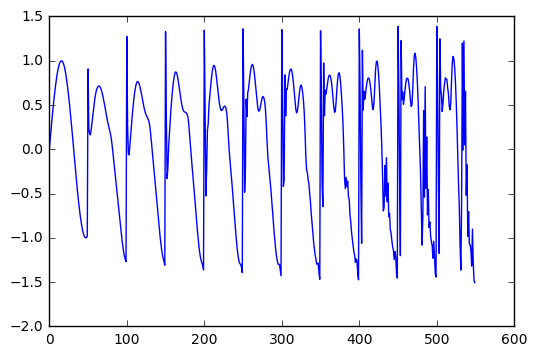

In [336]:
plt.plot(evaluate_BRNN(opt,10,c))

#### Basic Encoder-Decoder

In [337]:
class BasicEncDec(Chain):
    
    def __init__(self, input_dim=1, hidden_units=3, output_dim = 1, dec_output_dim = 1, rnn_type = "GRU"):
        super().__init__(

            encoder = BRNN(input_dim = input_dim, hidden_units = hidden_units,
                                output_dim=output_dim, rnn_type = rnn_type),

            fwd_rnn = Base_RNNs(input_dim = output_dim, hidden_units = hidden_units,
                                output_dim = dec_output_dim, rnn_type = rnn_type)    
        )
    
    def reset_state(self):
        self.encoder.reset_state()
        self.fwd_rnn.reset_state()
        
    def __call__(self, x):
        
        mid_y = self.encoder(x)
        
        y = [self.fwd_rnn(i) for i in mid_y]
        
        return y
    

In [346]:
BED_model = BasicEncDec(rnn_type = "RNN")

BED_modelC = Classifier_BRNN(BED_model)

opt = optimizers.Adam()
opt.setup(BED_modelC)

cuda.get_device(0).use()
BED_modelC.to_gpu()

In [ ]:
nb_epochs = 1000
backprop_interval = 1
batch_size = 100
sequence_length = 10

train_iter = SineIterator3(train_data, sequence_length, batch_size)
updater = BPTTUpdater_BRNN(train_iter,opt, backprop_interval,-1)
trainer = training.Trainer(updater,(nb_epochs,'epoch'))

trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'elapsed_time', 'main/loss']), trigger=(10, 'epoch'))
trainer.extend(extensions.PlotReport(['main/loss'], file_name='EncDec_loss.png'))
trainer.extend(extensions.ProgressBar(update_interval=1000))
trainer.extend(clear_screen,trigger=(9, 'epoch'))

trainer.run()

691         490.709       0.0332351   
692         491.388       0.0294406   
693         492.065       0.0333893   
694         492.744       0.029613    
695         493.422       0.0332481   
696         494.104       0.0300787   
697         494.782       0.0327043   
698         495.46        0.0308039   
699         496.139       0.0318112   
700         496.817       0.0317199   
     total [###################################...............] 70.00%
this epoch [..................................................]  0.00%
      7000 iter, 700 epoch / 1000 epochs
    14.065 iters/sec. Estimated time to finish: 0:03:33.292715.


In [ ]:
plt.plot(evaluate_BRNN(opt,10,c))

#### Basic Sequence2Sequence

# Tutorial 3 - Attention and Memory 

#### Sequence2Sequence with attention
#### End2End Memory Networks
#### Hierarchical Attentive Memory
#### Entity Networks`

# Tutorial 4 - Differentiable Computing
#### Neural Stack Machines
#### Neural Turing Machines
#### Neural GPUs
#### Neural Random Acces Machines
#### Neural Programmer-Interpreters
#### Differentiable Neural Computers
#### Adaptive Computation Time

# Tutorial 5 - Planning with DNNs

#### Value Iteration Networks
#### The Predictron
#### DeepStack
#### Mastering the game of Go

In [ ]:
from itertools import islice, chain

def batching(iterable, size):
    sourceiter = iter(iterable)
    while True:
        batchiter = islice(sourceiter, size)
        yield chain([batchiter.next()], batchiter)
        
train_iter = SineIterator1(train_data,batchsize)

sequences = batching(train_iter,sequence_length)

In [ ]:
sequence_length = 10 # backprop_interval now operates over sequences of length "sequnce_length"
nb_examples = train_data.shape[0] // sequence_length
nb_batches = nb_examples // batchsize

sequence_offsets = [sequence * sequence_length for sequence in range(nb_examples)]
batch_offsets = [batch * batchsize for batch in range(nb_batches)]

#print('Num of Examples: ',nb_examples, '\nNum of batches: ', nb_batches, '\nSequence offsets: ', sequence_offsets,
#     '\n\n\nBatch offsets: ', batch_offsets)

a = np.arange(batch_offsets[0],batch_offsets[0] + (batchsize*sequence_length)).reshape(batchsize,sequence_length)
#a